# Chapter IV: Improving Training of PINNs

This notebook covers techniques to improve the training of Physics-Informed Neural Networks (PINNs).

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
from pathlib import Path

from phd.models.allen_cahn import (
    train, evaluate, test_data, plot_results, 
    save_run_data, load_run, save_fields, load_fields, get_run_dir
)
from phd.config import load_config, copy_config, apply_overrides, print_config
from phd.plot import PlottingConfig, get_current_config, book_config, book_compact_config, A4_config

# --- Settings ---
save_fig = True

# Initialize plotting configuration
book_config.set_as_current()

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## IV_2: Fourier Feature Embedding

Fourier features help in learning high-frequency components.

### 1-Run/load model

In [ ]:
# === Fourier Features Experiments ===
# Run configurations to train (empty list = load all from disk)
configs_to_run_FF = ["spinn"]  # e.g. ["pinn", "spinn", "spinn_mod"]

# Load base config once
base_cfg = load_config("allen_cahn")

# Modify base settings for FF experiments
base_cfg.model.fourier_features.n_features = 128
base_cfg.model.fourier_features.sigma = 10
base_cfg.model.architecture.activations = "sin"
base_cfg.model.architecture.rank = 32
base_cfg.training.num_domain = 22500  # 150^2
base_cfg.training.n_iter = 100000
base_cfg.training.lr = 1e-5
base_cfg.training.lr_decay = ["warmup cosine", 1e-5, 1e-3, 1000, 100000, 1e-5]
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "pinn": {"model.net_type": "PINN", "model.fourier_features.n_features": 256},
    "spinn": {"model.net_type": "SPINN"},
    "spinn_mod": {"model.net_type": "SPINN", "model.architecture.mlp_type": "modified-mlp", "model.fourier_features.n_features": 64},
}

all_config_names_FF = list(model_variants.keys())
all_data_FF = {}

# === Train or Load each configuration ===
for config_name in all_config_names_FF:
    for ff_enabled in [False, True]:
        suffix = "_FF" if ff_enabled else ""
        run_name = config_name + suffix
        
        should_train = config_name in configs_to_run_FF
        
        if should_train:
            # Create a fresh copy and apply variant settings
            cfg = copy_config(base_cfg)
            cfg.model.fourier_features.enabled = ff_enabled
            apply_overrides(cfg, model_variants[config_name])
            
            print(f"Training: {run_name}")
            results = train(cfg)
            
            # Save using problem-specific wrapper
            save_run_data(results, run_name=run_name)
            
            # Store in memory (excluding model for memory efficiency)
            results.pop("model", None)
            all_data_FF[run_name] = results
        else:
            # Load existing run
            try:
                print(f"Loading: {run_name}")
                all_data_FF[run_name] = load_run(run_name)
            except FileNotFoundError:
                print(f"Warning: {run_name} not found")

# Text labels for plotting
config_text_dict = {
    "pinn": "PINN",
    "pinn_FF": "PINN + FF",
    "spinn": "SPINN",
    "spinn_FF": "SPINN + FF",
    "spinn_mod": "SPINN-mod",
    "spinn_mod_FF": "SPINN-mod + FF",
}

Training: spinn
Set the default automatic differentiation to forward mode.
Compiling model...


W1210 15:46:22.235554 2721887 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1210 15:46:22.240368 2721736 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


'compile' took 3.878105 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [8.22e-01]    [8.22e-01]    []  
0         [8.22e-01]    [8.22e-01]    []  
1000      [1.35e-01]    [1.35e-01]    []  
1000      [1.35e-01]    [1.35e-01]    []  
2000      [1.08e-01]    [1.08e-01]    []  
2000      [1.08e-01]    [1.08e-01]    []  
3000      [9.22e-02]    [9.22e-02]    []  
3000      [9.22e-02]    [9.22e-02]    []  
4000      [6.25e-02]    [6.25e-02]    []  
4000      [6.25e-02]    [6.25e-02]    []  
5000      [5.83e-02]    [5.83e-02]    []  
5000      [5.83e-02]    [5.83e-02]    []  
6000      [5.74e-02]    [5.74e-02]    []  
6000      [5.74e-02]    [5.74e-02]    []  
7000      [5.73e-02]    [5.73e-02]    []  
7000      [5.73e-02]    [5.73e-02]    []  
8000      [5.77e-02]    [5.77e-02]    []  
8000      [5.77e-02]    [5.77e-02]    []  
9000      [5.15e-02]    [5.15e-02]    []  
9000      [5.15e-0

### 2-Plot results

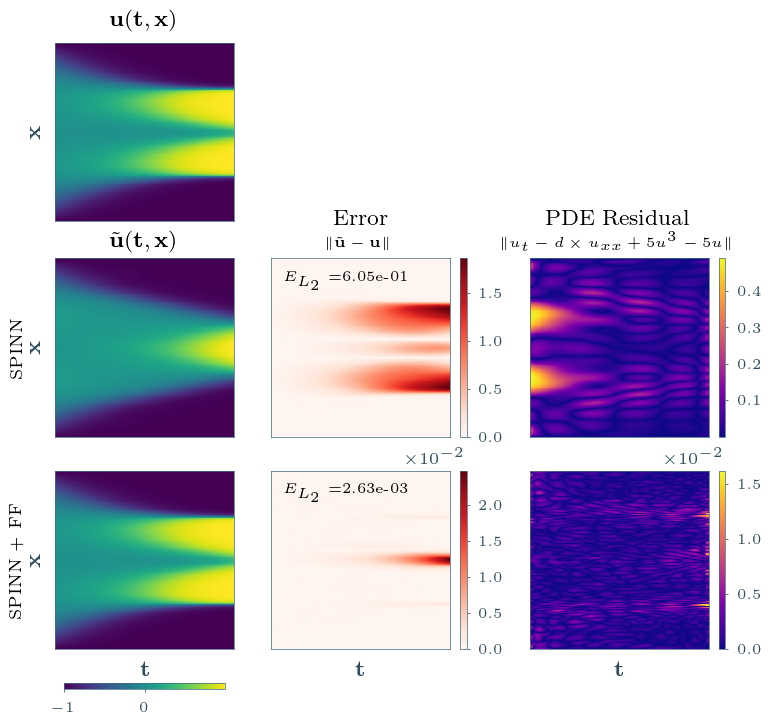

In [4]:
import matplotlib.transforms as mtransforms
from matplotlib import ticker

# Plotting configuration
book_config.set_as_current()
page_width = get_current_config().page_width
min_font_size = get_current_config().min_font_size

config_to_plot_FF = ["spinn"]  # e.g. ["pinn", "spinn", "spinn_mod"]

# Load test data
cfg_test = load_config("allen_cahn")
X, y, xx, tt, u_true_test = allen_cahn.test_data(cfg_test)
    
def fields_from_config(config_keys, all_data, config_text_dict, u_true_fallback=None):
    """Extract fields for plotting from loaded data."""
    u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []
    u_true = u_true_fallback
    
    for key in config_keys:
        if key not in all_data: 
            continue
        e = all_data[key]["evaluation"]
        u_true = e["u_true"]  # Update u_true from loaded data
        u_pred_all.append(e["u_pred"])
        u_diff_all.append(e["u_pred"] - u_true)
        pde_loss_all.append(e["pde_loss"])
        rows_title.append((e.get("l2_error", 1e9), config_text_dict.get(key, key)))

    if not rows_title:
        print(f"Warning: No data found for keys: {config_keys}")
        return [u_true] if u_true is not None else [], [], [], []
    
    order = sorted(range(len(rows_title)), key=lambda i: rows_title[i][0], reverse=True)
    u_pred_all = [u_pred_all[i] for i in order]
    u_diff_all = [u_diff_all[i] for i in order]
    pde_loss_all = [pde_loss_all[i] for i in order]
    rows_title = [rows_title[i][1] for i in order]
    u_pred_all = [u_true] + u_pred_all
    return u_pred_all, u_diff_all, pde_loss_all, rows_title

config_to_plot_FF_and_suffix = [c + suffix for c in config_to_plot_FF for suffix in ("", "_FF")]
u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(
    config_to_plot_FF_and_suffix, all_data_FF, config_text_dict, u_true_fallback=u_true_test
)
n_rows = len(rows_title) 

if n_rows > 0:
    fields_FF = {
        "Solution": {
            "data": u_pred_all,
            "title": r"$\tilde{\mathbf{u}}(\mathbf{t},\mathbf{x})$",
            "cmap": "viridis",
            "abs": False,
        },
        "Error": {
            "data": u_diff_all,
            "title": f"Error\n\\fontsize{{{min_font_size}}}{{{min_font_size}}} $\\|\\tilde{{\\mathbf{{u}}}} - \\mathbf{{u}}\\|$",
            "cmap": "Reds",
            "abs": True,
        },
        "PDE Residual": {
            "data": pde_loss_all,
            "title": "PDE Residual\n" + f"\\fontsize{{{min_font_size}}}{{{min_font_size}}} $\\|u_t - d \\times u_{{xx}} + 5u^3 - 5u\\|$",
            "cmap": "plasma",
            "abs": True,
        },
    }

    fig, ax = plt.subplots(1+n_rows, 3, figsize=(page_width, page_width/3.6*(n_rows+1)), dpi=200)
    allen_cahn.plot_results(fig, ax, fields_FF, tt, xx, rows_title)
    plt.show()

    # Save figure
    if save_fig:
        figure_folder = results_base_dir / "figures" / "FourierFeatures"
        figure_folder.mkdir(parents=True, exist_ok=True)
        figure_name = "+".join(config_to_plot_FF) + ".png"
        fig.savefig(figure_folder / figure_name, bbox_inches='tight', dpi=300)
else:
    print("No data to plot. Run training first or check that results exist.")

In [ ]:
import pandas as pd
from IPython.display import display

def build_results_df(all_data, config_text_dict=None, append_config=False):
    """Build a summary DataFrame from all_data dict."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        evaluation = entry.get("evaluation", {})
        l2 = evaluation.get("l2_error", np.nan)
        mean_pde = evaluation.get("mean_pde_residual", np.nan)
        iters_per_s = entry.get("iterations_per_sec", np.nan)
        elapsed = entry.get("elapsed_time", np.nan)
        name = config_text_dict.get(key, key) if config_text_dict is not None else key

        rows.append({
            "model_name": name,
            "l2_error": float(l2) if np.isfinite(l2) else np.nan,
            "mean_pde_residual": float(mean_pde) if np.isfinite(mean_pde) else np.nan,
            "iterations_per_sec": float(iters_per_s) if np.isfinite(iters_per_s) else np.nan,
            "elapsed_time_min": float(elapsed)/60 if np.isfinite(elapsed) else np.nan,
        })

        if append_config:
            config = entry.get("config", {})
            for k, v in config.items():
                if k not in rows[-1]:
                    rows[-1][k] = v

    df = pd.DataFrame(rows)
    df = df.sort_values("l2_error", ascending=False).reset_index(drop=True)
    return df

# Build and display results DataFrame
df_results_FF = build_results_df(all_data_FF, config_text_dict=config_text_dict)

display(
    df_results_FF.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Optionally save to LaTeX
# table_folder = results_base_dir / "tables" / "FourierFeatures"
# table_folder.mkdir(parents=True, exist_ok=True)
# with open(table_folder / "results.tex", 'w') as f:
#     f.write(df_results_FF.to_latex(index=False, float_format="%.2e", column_format="lcccc"))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
5,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_3: Self-Adaptive Attention

Self-adaptive attention mechanisms weight the PDE loss in some regions.

In [ ]:
# === Self-Attention Experiments ===
# Run configurations to train (empty list = load all from disk)
configs_to_run_SA = []#["weight_vis"]  # e.g. ["pinn_SA", "spinn_SA", "spinn_mod_SA", "weight_vis"]

# Load base config and modify for SA experiments
base_cfg_SA = load_config("allen_cahn")
base_cfg_SA.model.fourier_features.enabled = True
base_cfg_SA.model.fourier_features.n_features = 128
base_cfg_SA.model.fourier_features.sigma = 10
base_cfg_SA.model.net_type = "SPINN"
base_cfg_SA.model.architecture.activations = "sin"
base_cfg_SA.model.architecture.rank = 64
base_cfg_SA.training.num_domain = 22500
base_cfg_SA.training.n_iter = 100000
base_cfg_SA.training.lr = 1e-5
base_cfg_SA.training.lr_decay = ["warmup cosine", 1e-5, 1e-3, 1000, 100000, 1e-5]
base_cfg_SA.training.self_attention.enabled = True
base_cfg_SA.seed = 0

# Define SA model variants (only the differences from base)
model_variants_SA = {
    "pinn_SA": {"model.net_type": "PINN", "model.fourier_features.n_features": 256},
    "spinn_SA": {"model.net_type": "SPINN"},
    "spinn_mod_SA": {"model.net_type": "SPINN", "model.architecture.mlp_type": "modified-mlp"},
    "weight_vis": {"training.lr": 1e-3, "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 3000, 50000, 1e-5]},
}

all_config_names_SA = list(model_variants_SA.keys())
all_data_SA = {}
iters_pde_w = [500, 2500, 47000]  # Special iterations for weight visualization

# === Train or Load each configuration ===
for config_name in all_config_names_SA:
    run_name = config_name
    should_train = config_name in configs_to_run_SA
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg_SA)
        apply_overrides(cfg, model_variants_SA[config_name])
        
        if config_name == "weight_vis":
            # Special handling for weight visualization: train in stages
            print(f"Training: {run_name} (staged for weight visualization)")
            
            # Setup run directory
            run_dir = get_run_dir(run_name)
            run_dir.mkdir(parents=True, exist_ok=True)
            
            results_weight_vis = {}
            
            cfg_init = copy_config(cfg)
            cfg_init.training.n_iter = 0
            data_weight_vis = train(cfg_init)
            net = data_weight_vis.pop('model')
            
            for i, iter_ in enumerate(iters_pde_w):
                loss_history, _ = net.train(iter_)
                total_iter = sum(iters_pde_w[:i+1])
                results_weight_vis[total_iter] = evaluate(cfg, net)
                pde_w = net.external_trainable_variables[0].value
                results_weight_vis[total_iter]["pde_weights"] = pde_w
                
                # Save fields at this iteration
                save_fields(run_dir, total_iter, results_weight_vis[total_iter], pde_w)
                
                print(f"Iter {total_iter}: L2={results_weight_vis[total_iter]['l2_error']:.3e}, "
                      f"PDE={results_weight_vis[total_iter]['mean_pde_residual']:.3e}")
            
            data = {
                **data_weight_vis, 
                "results": results_weight_vis, 
                "config": cfg,
                "run_dir": str(run_dir),
            }
            all_data_SA[run_name] = data
            
            # Save metadata (the fields are already saved)
            save_run_data(data, run_name=run_name)
        else:
            print(f"Training: {run_name}")
            results = train(cfg)
            
            save_run_data(results, run_name=run_name)
            
            results.pop("model", None)
            all_data_SA[run_name] = results
    else:
        try:
            print(f"Loading: {run_name}")
            all_data_SA[run_name] = load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

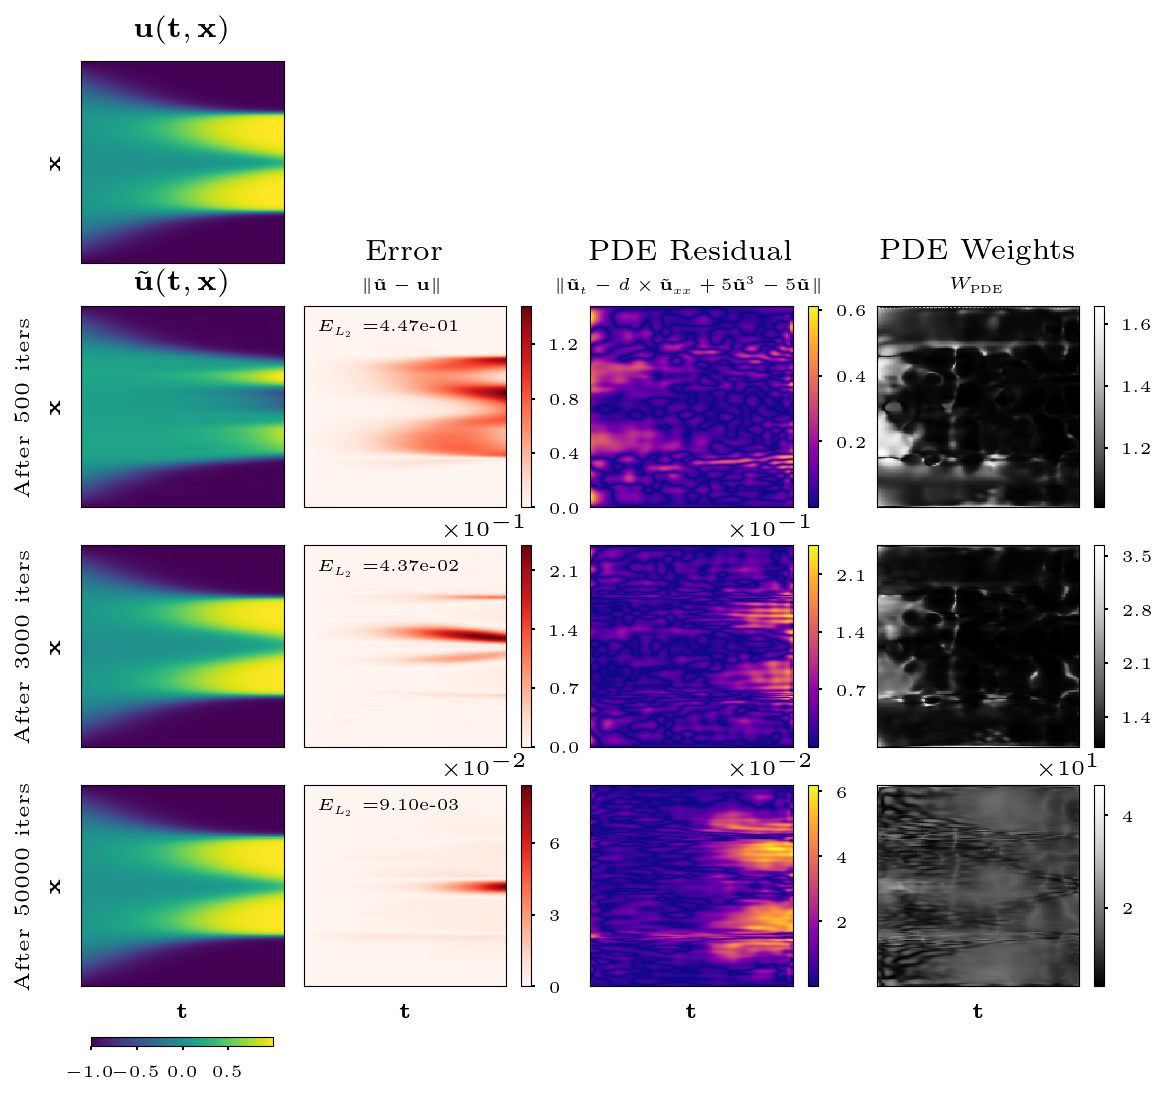

In [ ]:
# === Plot Weight Visualization ===
book_compact_config.set_as_current()
page_width = get_current_config().page_width
min_font_size = get_current_config().min_font_size

# Load test data grid
cfg_test = load_config("allen_cahn")
X, y, xx, tt, u_true = allen_cahn.test_data(cfg_test)
X_train = [np.linspace(-1, 1, 150), np.linspace(0, 1, 150)]
x_train, t_train = np.meshgrid(X_train[0], X_train[1])

if "weight_vis" in all_data_SA and "results" in all_data_SA["weight_vis"]:
    # Plot evaluation at different PDE weight iterations
    u_pred_all, pde_loss_all, pde_weights_all = [], [], []
    results_weight_vis = all_data_SA["weight_vis"]["results"]
    for k in sorted(results_weight_vis.keys()):
        u_pred_all.append(results_weight_vis[k]["u_pred"])
        pde_loss_all.append(results_weight_vis[k]["pde_loss"])
        pde_weights_all.append(results_weight_vis[k]["pde_weights"].reshape(x_train.shape).T)

    # Use ground truth from any entry
    u_true = results_weight_vis[min(results_weight_vis.keys())]["u_true"]
    u_diff_all = [u - u_true for u in u_pred_all]

    rows_title = [f"After {k} iters" for k in sorted(results_weight_vis.keys())]

    fields_SA_weight_vis = {
        "Solution": {
            "data": [u_true] + u_pred_all,
            "title": r"$\tilde{\mathbf{u}}(\mathbf{t},\mathbf{x})$",
            "cmap": None,
            "abs": False,
        },
        "Error": {
            "data": u_diff_all,
            "title": f"Error\n\\fontsize{{{min_font_size}}}{{{min_font_size}}} $\\|\\tilde{{\\mathbf{{u}}}} - \\mathbf{{u}}\\|$",
            "cmap": "Reds",
            "abs": True,
        },
        "PDE Residual": {
            "data": pde_loss_all,
            "title": f"PDE Residual\n\\fontsize{{{min_font_size}}}{{{min_font_size}}}$\\|\\tilde{{\\mathbf{{u}}}}_t - d \\times \\tilde{{\\mathbf{{u}}}}_{{xx}} + 5\\tilde{{\\mathbf{{u}}}}^3 - 5\\tilde{{\\mathbf{{u}}}}\\|$",
            "cmap": "plasma",
            "abs": True,
        },
        "PDE Weights": {
            "data": pde_weights_all,
            "title": f"PDE Weights\n\\fontsize{{{min_font_size}}}{{{min_font_size}}}$W_\\text{{PDE}}$",
            "cmap": "Greys_r",
            "abs": False,
            "x_fields": x_train,
            "t_fields": t_train,
        },
    }

    fig, ax = plt.subplots(4, 4, figsize=(page_width, 0.85*page_width), dpi=300)
    allen_cahn.plot_results(fig, ax, fields_SA_weight_vis, tt, xx, rows_title, powerlimits=(-1, 1))

    if save_fig:
        figure_folder = results_base_dir / "figures" / "SelfAttention"
        figure_folder.mkdir(parents=True, exist_ok=True)
        (figure_folder / "pdf").mkdir(exist_ok=True)
        fig.savefig(figure_folder / "weight_vis.png", bbox_inches='tight', dpi=300)
        fig.savefig(figure_folder / "pdf" / "weight_vis.pdf", bbox_inches='tight')
else:
    print("No weight_vis data found. Run SA experiments with 'weight_vis' in configs_to_run_SA first.")

150.0


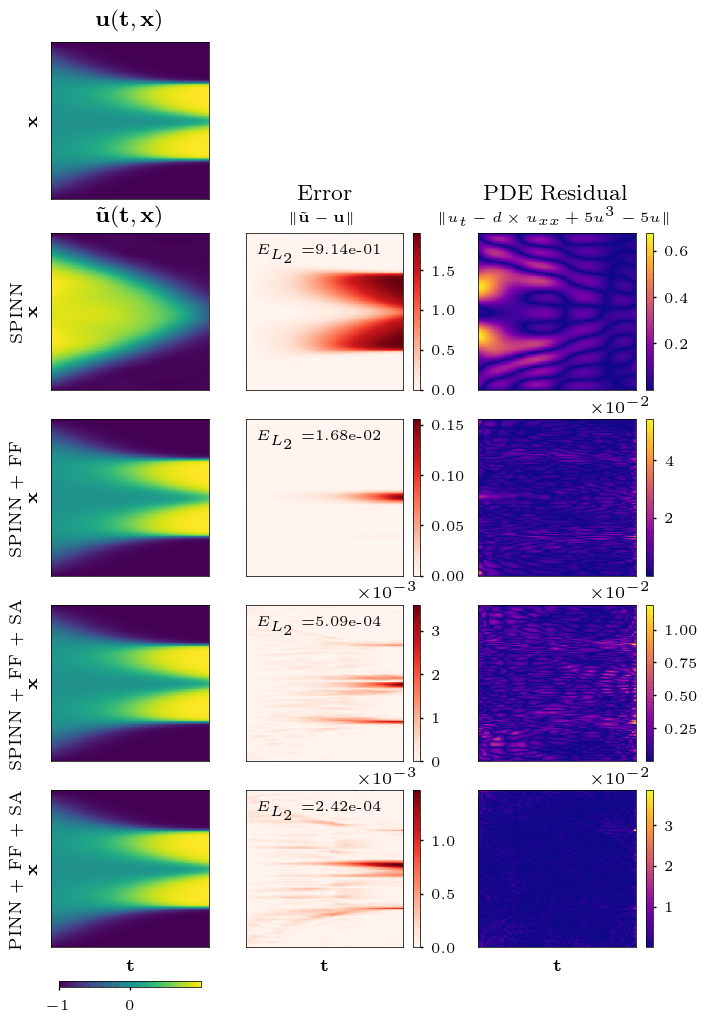

In [ ]:
# === Combined FF + SA Comparison Plot ===
book_config.set_as_current()
page_width = get_current_config().page_width
min_font_size = get_current_config().min_font_size

# Combine all data for comparison
all_data_FF_SA = {**all_data_FF, **all_data_SA}
config_to_plot_FF_SA = ["spinn", "spinn_FF", "spinn_SA", "pinn_SA"]

config_text_dict_FF_SA = {
    **config_text_dict,
    "pinn_SA": "PINN + FF + SA",
    "spinn_SA": "SPINN + FF + SA",
    "spinn_mod_SA": "SPINN-mod + FF + SA",
}

u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(
    config_to_plot_FF_SA, all_data_FF_SA, config_text_dict_FF_SA
)
n_rows = len(rows_title) 

fields_FF_SA = {
    "Solution": {
        "data": u_pred_all,
        "title": r"$\tilde{\mathbf{u}}(\mathbf{t},\mathbf{x})$",
        "cmap": "viridis",
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": f"Error\n\\fontsize{{{min_font_size}}}{{{min_font_size}}} $\\|\\tilde{{\\mathbf{{u}}}} - \\mathbf{{u}}\\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + f"\\fontsize{{{min_font_size}}}{{{min_font_size}}} $\\|u_t - d \\times u_{{xx}} + 5u^3 - 5u\\|$",
        "cmap": "plasma",
        "abs": True,
    },
}

fig_width = page_width * 0.9
fig_height = min(fig_width / 3.6 * (n_rows + 1), 160 / 25.4)  # max height of 160mm
print(f"Figure height: {fig_height * 25.4:.1f} mm")

fig, ax = plt.subplots(1 + n_rows, 3, figsize=(fig_width, fig_height), dpi=200)
allen_cahn.plot_results(fig, ax, fields_FF_SA, tt, xx, rows_title)

if save_fig:
    figure_folder = results_base_dir / "figures" / "Combined"
    figure_folder.mkdir(parents=True, exist_ok=True)
    (figure_folder / "pdf").mkdir(exist_ok=True)
    fig.savefig(figure_folder / "full_comparison.png", bbox_inches='tight', dpi=300)
    fig.savefig(figure_folder / "pdf" / "full_comparison.pdf", bbox_inches='tight')

In [10]:
6.561679790026247 * 25.4

166.66666666666666

In [ ]:
# === Combined Results Table (FF + SA) ===
df_results_all = build_results_df(all_data_FF_SA, config_text_dict=config_text_dict_FF_SA)

# Remove weight_vis rows from the table
df_results_all = df_results_all[
    ~df_results_all["model_name"].astype(str).str.contains("weight_vis", case=False)
].reset_index(drop=True)

display(
    df_results_all.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save to LaTeX
if save_fig:
    table_folder = results_base_dir / "tables" / "SelfAttention"
    table_folder.mkdir(parents=True, exist_ok=True)
    with open(table_folder / "results.tex", 'w') as f:
        f.write(df_results_all.to_latex(index=False, float_format="%.2e", column_format="lcccc"))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF + SA,1.67e-03,2.07e-03,367.68,3.63
5,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
6,SPINN + FF + SA,5.09e-04,1.09e-03,284.13,4.69
7,PINN + FF + SA,2.42e-04,6.83e-04,270.55,4.93
8,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_4: Hyperparameter Optimization with Wandb Sweeps

Use Wandb sweeps for systematic hyperparameter optimization. The sweep configurations below are based on the YAML files in `examples/allen_cahn/HPO/`.

In [ ]:
# === Wandb Sweep Configuration using phd.io utilities ===
import numpy as np
from phd.io import setup_wandb_sweep, get_sweep_commands, setup_wandb_environment

# Problem and project settings
PROBLEM = "allen_cahn"
PROJECT = "Allen-Cahn"

# === Sweep configurations (using Hydra parameter paths) ===
sweep_config_pinn = {
    'name': 'pinn_sweep',
    'method': 'grid',
    'metric': {'name': 'l2_error', 'goal': 'minimize'},
    'parameters': {
        'model.net_type': {'value': 'PINN'},
        'model.architecture.n_fourier_features': {'values': [128, 256]},
        'model.architecture.activations': {'values': ['tanh', 'sin']},
        'problem.n_domain': {'value': 22500},  # 150**2
        'training.n_iter': {'value': 100000},
        'seed': {'values': [0, 1, 2, 3]},
        'model.fourier_features.enabled': {'value': True},
        'training.lr': {'value': 1e-5},
        'training.lr_decay': {'values': [
            ['warmup cosine', 1e-5, 1e-3, 1000, 100000, 1e-5],
            ['exponential', 1e-3, 2000, 0.9]
        ]},
        'training.self_attention.enabled': {'values': [False, True]},
    }
}

sweep_config_spinn = {
    'name': 'spinn_sweep',
    'method': 'grid',
    'metric': {'name': 'l2_error', 'goal': 'minimize'},
    'parameters': {
        'model.net_type': {'value': 'SPINN'},
        'model.architecture.n_fourier_features': {'values': [32, 64]},
        'model.architecture.activations': {'values': ['tanh', 'sin']},
        'problem.n_domain': {'value': 22500},  # 150**2 
        'model.architecture.mlp_type': {'values': ['mlp', 'modified-mlp']},
        'model.architecture.rank': {'values': [32, 64]},
        'seed': {'values': [0, 1, 2, 3]},
        'model.fourier_features.enabled': {'value': True},
        'training.n_iter': {'value': 100000},
        'training.lr': {'value': 1e-5},
        'training.lr_decay': {'values': [
            ['cosine', 1e-3, 100000, 1e-5],
            ['warmup cosine', 1e-5, 1e-3, 1000, 100000, 1e-5],
            ['warmup exponential', 1e-5, 1e-3, 1000, 2000, 0.9]
        ]},
        'training.self_attention.enabled': {'values': [False, True]},
    }
}

# === Sweep creation ===
SWEEP_TYPE = 'spinn'  # 'pinn' or 'spinn'
sweep_configs = {'pinn': sweep_config_pinn, 'spinn': sweep_config_spinn}
sweep_config = sweep_configs[SWEEP_TYPE]

# Helper: count total runs
def count_combinations(cfg):
    return np.prod([len(p['values']) if 'values' in p else 1 for p in cfg['parameters'].values()])

n_runs = count_combinations(sweep_config)
print(f"📊 Expected number of runs: {n_runs}")

# Create or use existing sweep
CREATE_SWEEP = False
if CREATE_SWEEP:
    sweep_id = setup_wandb_sweep(
        problem=PROBLEM,
        sweep_config=sweep_config,
        project=PROJECT,
        sweep_name=f"{SWEEP_TYPE}_hpo"
    )
    print(f"✅ Created sweep: {sweep_id}")
else:
    existing_sweeps = {"spinn": "fyzp6zoi", "pinn": "fyzp6zoi"}
    sweep_id = existing_sweeps[SWEEP_TYPE]
    # Setup environment for existing sweep
    sweep_dir = setup_wandb_environment(PROBLEM, sweep_name=f"{SWEEP_TYPE}_hpo")
    print(f"ℹ️ Using existing sweep: {sweep_id}")
    print(f"📁 Results directory: {sweep_dir}")

# Generate CLI commands
import wandb
entity = wandb.api.default_entity
commands = get_sweep_commands(
    sweep_id=sweep_id,
    problem=PROBLEM,
    project=PROJECT,
    entity=entity,
    sweep_name=f"{SWEEP_TYPE}_hpo"
)
print("\n" + "="*70)
print("🚀 RUN IN TERMINAL:")
print("="*70)
print(commands)

ℹ️ Using existing sweep: fyzp6zoi
📊 Expected number of runs: 128

🚀 RUN IN TERMINAL:
cd /home/bonneted/PhD/examples/allen_cahn
conda activate jax
export WANDB_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch
export WANDB_DATA_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch/wandb_cache
wandb agent None/Allen-Cahn/fyzp6zoi

🚀 RUN IN TERMINAL:
cd /home/bonneted/PhD/examples/allen_cahn
conda activate jax
export WANDB_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch
export WANDB_DATA_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch/wandb_cache
wandb agent None/Allen-Cahn/fyzp6zoi


In [3]:
import os, json, pandas as pd, wandb

LOAD_RUNS_FROM_WANDB = False
ENTITY, PROJECT = "damien-bonnet", "Allen-Cahn"
sweep_results_folder = os.path.join(results_folder, 'Sweeps')

def load_project_results(ENTITY, PROJECT):
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{PROJECT}")

    unwrap = lambda v: v['value'] if isinstance(v, dict) and len(v) == 1 and 'value' in v else v

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary = {k: unwrap(v) for k, v in json.loads(run.summary._json_dict).items() if not k.startswith('_')}
        config = {k: unwrap(v) for k, v in json.loads(run.config).items() if not k.startswith('_')}
        summary_list.append(summary)
        config_list.append(config)
        name_list.append(run.name)

    # Flatten into single row per run
    runs_df = pd.DataFrame([
        {"run_name": name} | {k: v for k, v in config.items() if k not in summary} | summary
        for name, config, summary in zip(name_list, config_list, summary_list)
    ])
    print(f"Loaded {len(runs_df)} runs from wandb.")
    return runs_df


if LOAD_RUNS_FROM_WANDB:
    runs_df = load_project_results(ENTITY, PROJECT)
    # Save to CSV
    runs_df.to_csv(os.path.join(sweep_results_folder, f'AllRuns_{PROJECT}.csv'), index=False)
else:
    runs_df = pd.read_csv(os.path.join(sweep_results_folder, f'AllRuns_{PROJECT}.csv'))
    print(f"Loaded {len(runs_df)} runs from CSV.")

Loaded 841 runs from CSV.


In [4]:
# Display aggregated results 
cols = [c for c in ["net_type","mlp_type", "activations", "n_fourier_features", "lr_decay", "rank"] if c in runs_df]
#not considering 'n_domain' as both 150**2 and 200**2 yield exact same results

runs_df_clean = runs_df.copy()
runs_df_clean["lr_decay"] = runs_df_clean["lr_decay"].apply(lambda x: x.strip("['']").split("',")[0] if isinstance(x, str) else x)

mask = (runs_df_clean["mlp_type"] == "modified-mlp")
runs_df_clean.loc[mask, "activations"] = 'sin/tanh' # same results observed for both activations with modified-mlp
runs_df_clean["elapsed_time"] = runs_df_clean["elapsed_time_s"]/60

agg = (runs_df_clean.groupby(cols)
            .agg(mean_l2=("l2_relative_error","mean"),
                std_l2=("l2_relative_error","std"),
                min_l2=("l2_relative_error","min"),
                max_l2=("l2_relative_error","max"),
                elapsed_time=("elapsed_time","mean"),
                iter_per_sec=("iterations_per_sec","mean"),
                count=("l2_relative_error","count"))
            .reset_index()
            .sort_values("mean_l2"))

# display(agg.style.background_gradient(cmap="Greens_r",subset=["mean_l2","min_l2","max_l2"])
#                         .background_gradient(cmap="Reds",subset=["std_l2"])
#                         .format("{:.2e}",subset=["mean_l2","std_l2","min_l2","max_l2"])
#                         .format("{:.1f}",subset=["elapsed_time","iter_per_sec"]))
